In [1]:
# !wget --no-check-certificate \
#     https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#     -O ./dataset/time_series_daily_min_temperatures.csv

--2021-01-14 03:52:01--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: './dataset/time_series_daily_min_temperatures.csv'

     0K .......... .......... .......... .......... .......... 75% 1.66M 0s
    50K .......... ......                                     100% 5.83M=0.03s

2021-01-14 03:52:01 (2.02 MB/s) - './dataset/time_series_daily_min_temperatures.csv' saved [67921/67921]



In [2]:
import csv
time_step = []
temps = []

with open("./dataset/time_series_daily_min_temperatures.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

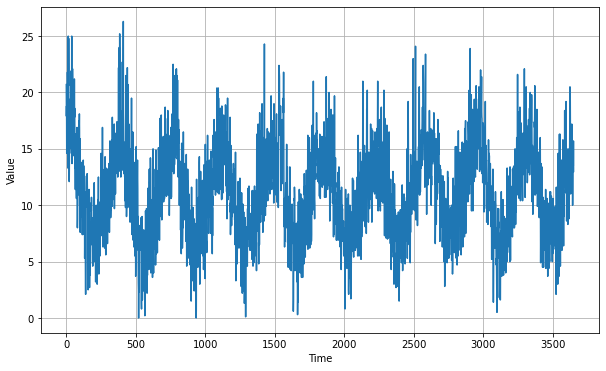

In [3]:
import numpy as np
import matplotlib.pyplot as plt

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

In [4]:
split_time = 2500

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
import tensorflow as tf

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae", "map"])
history = model.fit(train_set, epochs=100)

Epoch 1/100
10/10 [==============================] - 2s 157ms/step - loss: 26.7819 - mae: 27.2786
Epoch 2/100
10/10 [==============================] - 1s 132ms/step - loss: 9.3389 - mae: 9.8300
Epoch 3/100
10/10 [==============================] - 1s 138ms/step - loss: 3.6397 - mae: 4.1173
Epoch 4/100
10/10 [==============================] - 1s 137ms/step - loss: 2.4198 - mae: 2.8835
Epoch 5/100
10/10 [==============================] - 1s 134ms/step - loss: 2.0353 - mae: 2.4920
Epoch 6/100
10/10 [==============================] - 1s 138ms/step - loss: 1.8166 - mae: 2.2681
Epoch 7/100
10/10 [==============================] - 1s 130ms/step - loss: 1.6993 - mae: 2.1478
Epoch 8/100
10/10 [==============================] - 1s 132ms/step - loss: 1.6457 - mae: 2.0914
Epoch 9/100
10/10 [==============================] - 1s 137ms/step - loss: 1.6194 - mae: 2.0651
Epoch 10/100
10/10 [==============================] - 1s 136ms/step - loss: 1.5983 - mae: 2.0431
Epoch 11/100
10/10 [=================

10/10 [==============================] - 2s 159ms/step - loss: 1.4603 - mae: 1.8990
Epoch 86/100
10/10 [==============================] - 2s 160ms/step - loss: 1.4745 - mae: 1.9149 0s - loss: 1.6139 - ma
Epoch 87/100
10/10 [==============================] - 2s 166ms/step - loss: 1.4414 - mae: 1.8786 0s - loss: 1.4558 - mae: 1
Epoch 88/100
10/10 [==============================] - 2s 156ms/step - loss: 1.4982 - mae: 1.9401
Epoch 89/100
10/10 [==============================] - 1s 149ms/step - loss: 1.5212 - mae: 1.9638
Epoch 90/100
10/10 [==============================] - 2s 154ms/step - loss: 1.4344 - mae: 1.8712
Epoch 91/100
10/10 [==============================] - 2s 151ms/step - loss: 1.5000 - mae: 1.9423
Epoch 92/100
10/10 [==============================] - 1s 148ms/step - loss: 1.4908 - mae: 1.9320
Epoch 93/100
10/10 [==============================] - 1s 148ms/step - loss: 1.5041 - mae: 1.9462
Epoch 94/100
10/10 [==============================] - 1s 146ms/step - loss: 1.4352 - mae: 

In [8]:
ds = tf.data.Dataset.from_tensor_slices(series[..., np.newaxis])
ds = ds.window(window_size, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda w: w.batch(window_size))
ds = ds.batch(32).prefetch(1)

rnn_forecast = model.predict(ds)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.8120569

<Figure size 432x288 with 0 Axes>

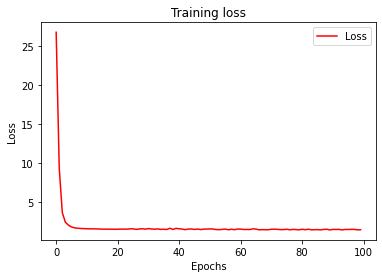

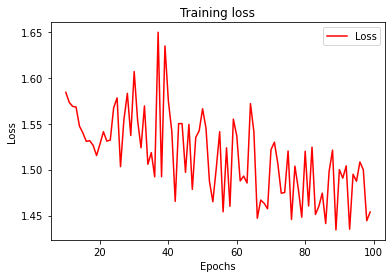

<Figure size 432x288 with 0 Axes>

In [12]:
loss = history.history["loss"]

epochs=range(len(loss))

zoomed_loss = loss[10:]
zoomed_epochs = range(10, 100)

plt.plot(epochs, loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

plt.plot(zoomed_epochs, zoomed_loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()